In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import shutil
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
!pip install wandb -qU
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
root_dir = '/content/mnist_train_data'
os.makedirs(root_dir, exist_ok=True)
# change the range to number of classes in dataset
for i in range(10):
    os.makedirs(os.path.join(root_dir, str(i)), exist_ok=True)

In [6]:
trainset = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4561584.26it/s]


Extracting /content/mnist_train_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/mnist_train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133135.17it/s]


Extracting /content/mnist_train_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/mnist_train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242177.39it/s]


Extracting /content/mnist_train_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/mnist_train_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4418026.15it/s]

Extracting /content/mnist_train_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/mnist_train_data/MNIST/raw



In [7]:
class_names = trainset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
def save_images_to_folders(dataset, root_dir):
    for idx, (image, label) in enumerate(tqdm(dataset)):
        label_dir = os.path.join(root_dir, str(label))
        img_path = os.path.join(label_dir, f'{idx}.png')
        torchvision.utils.save_image(image, img_path)

In [9]:
save_images_to_folders(trainset, root_dir)

100%|██████████| 60000/60000 [00:39<00:00, 1523.26it/s]


In [11]:
shutil.rmtree('/content/mnist_train_data/MNIST')

In [12]:
test_dir = '/content/mnist_test_data'
os.makedirs(test_dir, exist_ok=True)
for i in range(10):
    os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

testset = torchvision.datasets.MNIST(root=test_dir, train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(trainset, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5051741.49it/s]


Extracting /content/mnist_test_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/mnist_test_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133346.65it/s]


Extracting /content/mnist_test_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/mnist_test_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1081885.33it/s]


Extracting /content/mnist_test_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/mnist_test_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4037839.93it/s]

Extracting /content/mnist_test_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/mnist_test_data/MNIST/raw



In [13]:
shutil.rmtree('/content/mnist_test_data/MNIST')

In [14]:
save_images_to_folders(testset, test_dir)

100%|██████████| 10000/10000 [00:06<00:00, 1541.06it/s]


In [15]:
import os
import pandas as pd

# initialise annotation file names here

train_annotation = 'annotations_mnist_train.csv'
test_annotation = 'annotations_mnist_test.csv'

def create_annotations_csv(root_dir, output_file):
    data = []

    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                if os.path.isfile(file_path):
                    data.append([f"{label}/{file_name}", label])

    df = pd.DataFrame(data, columns=['filepath', 'label'])

    df.to_csv(output_file, index=False)

    print(f"{output_file} file created successfully.")

create_annotations_csv(root_dir, train_annotation)
create_annotations_csv(test_dir, test_annotation)

annotations_mnist_train.csv file created successfully.
annotations_mnist_test.csv file created successfully.


In [16]:
config = {
    "learning_rate": 0.01,
    "batch_size": 64,
    "epochs": 5,
}

In [17]:
project_name = 'Conformal Prediction Experiments'
run_name = 'MNIST'
github_url_base = 'https://github.com/Aadharsh1/ML-Deep-Learning/blob/main/Weights_Biases'
file_name = f'{run_name}.ipynb'
notebook_link = f'{github_url_base}/{project_name}/{file_name}'

run = wandb.init(
    project=project_name,
    name=run_name,
    notes=notebook_link,
    config=config,
    )

annotations_path = f'/content/{train_annotation}'
labels_at = wandb.Artifact("train_annotations", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

annotations_path = f'/content/{test_annotation}'
labels_at = wandb.Artifact("test_annotations", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

wandb: Currently logged in as: aadharshr-2022 (aadharshr-2022-Singapore Management University). Use `wandb login --relogin` to force relogin


<Artifact test_annotations>

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pandas as pd
from PIL import Image

class Dataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("L")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [19]:
train_dataset = Dataset(annotations_file=f'/content/{train_annotation}', img_dir=root_dir, transform=transforms.ToTensor())
test_dataset = Dataset(annotations_file=f'/content/{test_annotation}', img_dir=test_dir, transform=transforms.ToTensor())


In [20]:
from torch.utils.data import DataLoader, random_split
calibration_size = int(0.02*len(train_dataset))
remaining_size = len(train_dataset) - calibration_size
calibration_set, train_set = random_split(train_dataset, [calibration_size, remaining_size])


In [21]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
calib_loader = DataLoader(calibration_set, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

In [22]:
class model1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(490, out_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = model1(1, 10, 10).to(device)

In [23]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=config['learning_rate'])

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))


def validate_function(model, device, validation_dataloader, loss_function, accuracy_function):
  model.eval()
  model = model.to(device)
  validation_loss = 0
  validation_acc = 0

  with torch.inference_mode():
    for X_val, y_val in tqdm(validation_dataloader):
      X_val , y_val = X_val.to(device), y_val.to(device)
      val_logits = model(X_val)
      val_pred = torch.argmax(val_logits, dim=1)
      validation_acc += accuracy_function(y_val, val_pred)
      validation_loss += loss_function(val_logits, y_val)
  return validation_loss/len(validation_dataloader), validation_acc/len(validation_dataloader)

In [25]:
epochs = config['epochs']
for epoch in range(epochs):
  train_loss, trng_acc = train_function(model, device, train_loader, loss_fn, optimizer)
  val_loss, val_acc = validate_function(model, device, test_loader, loss_fn, accuracy_function)
  wandb.log({
        'training_loss': train_loss,
        'training_accuracy': trng_acc,
        'test_loss': val_loss,
        'test_accuracy': val_acc
    })
  print(f'Epoch {epoch}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f} ')

  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0: Training Loss: 2.2896, Training Accuracy: 19.5440 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.5557, Training Accuracy: 83.4881 


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.2063, Training Accuracy: 93.8384 


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.1420, Training Accuracy: 95.7223 


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.1164, Training Accuracy: 96.4715 


In [26]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calib_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
n = len(calibration_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.26173282

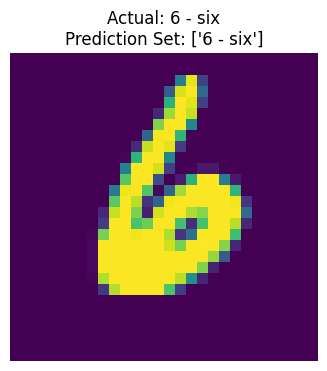

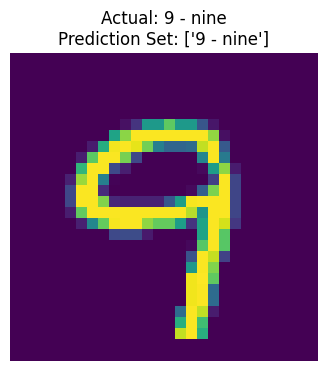

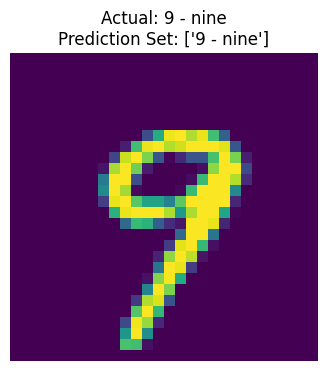

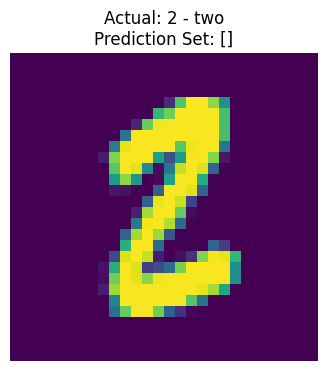

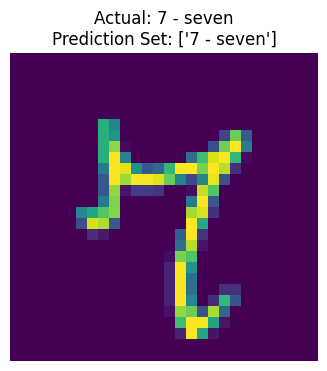

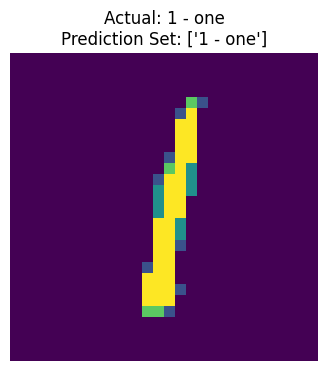

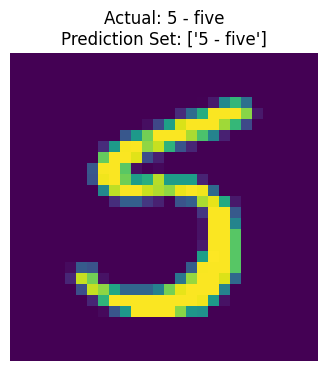

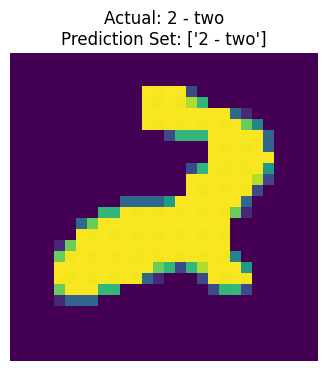

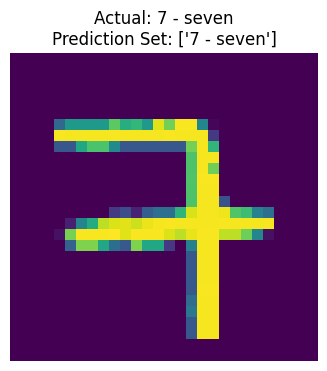

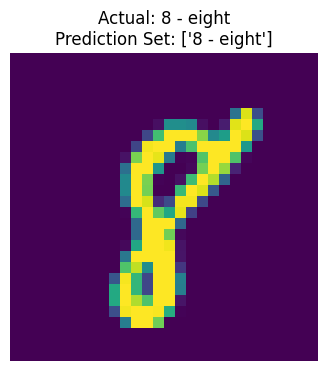

In [28]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(test_dataset)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_dataset, selected_indices)
import matplotlib.pyplot as plt

prediction_sets = []
class_names = trainset.classes
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().squeeze())
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

In [66]:
project_name = wandb.run.project
run_name = wandb.run.name
# change notebook name according to name of current notebook
notebook_path = '/content/drive/MyDrive/Colab Notebooks/fmnist_annotations.ipynb'

In [67]:
url_path = '/content/drive/MyDrive/github_url.txt'
with open(url_path, 'r') as file:
    github_url = file.read().strip()

In [68]:
import os
import subprocess
import shutil
directory = project_name
file_name = f"{run_name}.ipynb"
file_path = os.path.join('/content/ML-Deep-Learning/Weights_Biases', directory, file_name)

In [81]:
#shutil.rmtree('/content/ML-Deep-Learning')

In [1]:
repo_path = '/content/ML-Deep-Learning'
if not os.path.exists(repo_path):
    subprocess.run(["git", "clone", github_url, repo_path])

os.chdir(repo_path)

NameError: name 'os' is not defined

In [82]:
project_directory = os.path.join('Weights_Biases', directory)
if not os.path.exists(project_directory):
    os.makedirs(project_directory)
    print(f"Directory '{project_directory}' created.")
else:
    print(f"Directory '{project_directory}' already exists.")

FileNotFoundError: [Errno 2] No such file or directory: 'Weights_Biases'

In [71]:
shutil.copyfile(notebook_path, file_path)

'/content/ML-Deep-Learning/Weights_Biases/Conformal Prediction Experiments/MNIST 1.ipynb'

In [72]:
!git config --global user.email "aadharshrajagopal1@gmail.com"
!git config --global user.name "Aadharsh1"
!git remote set-url origin {github_url}

In [73]:
!cd /content/ML-Deep-Learning/Weights_Biases

In [74]:
!git add .

In [75]:
!git commit -m "Add notebook"

[main df01a06] Add notebook
 12 files changed, 2063 insertions(+), 3 deletions(-)
 create mode 100644 Weights_Biases/Conformal Prediction Experiments/MNIST 1.ipynb
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/files/config.yaml
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/files/output.log
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/files/requirements.txt
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/files/wandb-metadata.json
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/files/wandb-summary.json
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/logs/debug-internal.log
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/logs/debug.log
 create mode 100644 wandb/run-20240703_081251-ri2mpw41/run-ri2mpw41.wandb


In [76]:
!git push origin main

To https://github.com/Aadharsh1/ML-Deep-Learning.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/Aadharsh1/ML-Deep-Learning.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [48]:
wandb.finish()

test_accuracy,▁█████████
test_loss,█▂▁▁▁▁▁▁▁▁
training_accuracy,▁▆████████
training_loss,█▄▁▁▁▁▁▁▁▁
test_accuracy,98.21855
test_loss,0.05538
training_accuracy,98.08952
training_loss,0.0636
